In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

Single sampling

In [3]:
from limit_states.pushover_concentrated import PushoverConcetrated_mod

# Mybeam_mean = 10938.0   # yield moment at plastic hinge location (i.e., My of RBS section, if used)
Mybeam_mean = 14938.0
Mybeam_std = Mybeam_mean * 0.10

# Mycol_mean = 20350.0   # yield moment of colum section
Mycol_mean = 23350.0
Mycol_std = Mycol_mean * 0.10

# Es_mean = 29000.0  # steel Young's modulus
# Es_std = Es_mean * 0.10

Acol_12_mean = 38.5     # cross-sectional area column section W24x131 for Story 1 & 2 (elasticBeamColumn: 111, 121, 112, 122)
Acol_12_std = Acol_12_mean*0.10

# Abeam_23_mean = 30.0      # cross-sectional area (full section properties)(elasticBeamColumn: 212, 222)
# Abeam_23_std = Abeam_23_mean*0.10

dim = 3
x_sample = np.zeros(dim)

# random sampling (gaussian distribution)
x_sample[0] = np.random.normal(Mybeam_mean, Mybeam_std)   # yield moment at plastic hinge location
x_sample[1] = np.random.normal(Mycol_mean, Mycol_std)   # yield moment of colum section
x_sample[2] = np.random.normal(Acol_12_mean, Acol_12_std)  # cross-sectional area (elasticBeamColumn: 111, 121, 112, 122)

# x_sample[2] = np.random.normal(Es_mean, Es_std)   # Steel Young's modulus
# x_sample[4] = np.random.normal(Abeam_23_mean, Abeam_23_std) # cross-sectional area (full section properties)(elasticBeamColumn: 212, 222)

# x_sample[0] = x_samples[i][0]
# x_sample[1] = x_samples[i][1]
# x_sample[2] = x_samples[i][2]
# x_sample[3] = x_samples[i][3]
# x_sample[4] = x_samples[i][4]

# print(x_sample)

data, max_displacement, max_baseshear = PushoverConcetrated_mod(x_sample)

# plt.scatter(data[:,0], data[:,2], s=5)
# plt.xlabel('Horizontal Displacement')
# plt.ylabel('Base shear')
# plt.show()
print(f'Max_baseshear: {max_baseshear} at Max_displacement: {max_displacement}')

Max_baseshear: 356.3174332377223 at Max_displacement: 2.509558835881696


Modified Ibarra-Medina-Krawinkler Model with Bilinear Hysteretic Response


In [4]:
# Applying lateral loads
lat2 = 16.255
lat3 = 31.636
ratio_ref = lat3/lat2

MC sampling

In [ ]:
# random sampling
n_samples = 10
dim = 4

x_mc_samples = np.zeros((int(n_samples), dim))
x_mc_samples[:,0] = np.random.normal(Mybeam_mean, Mybeam_std, int(n_samples))
x_mc_samples[:,1] = np.random.normal(Mycol_mean, Mycol_std, int(n_samples))
x_mc_samples[:,2] = np.random.normal(Acol_12_mean, Acol_12_std , int(n_samples))
x_mc_samples[:,3] = np.random.normal(35.0, 35.0 * 0.25 , int(n_samples))

In [10]:
from limit_states import REGISTRY as ls_REGISTRY

lstate = ls_REGISTRY['pushover_frame']()

In [11]:
Pf_ref, B_ref, x_mc_scaled, y_mc = lstate.monte_carlo_estimate(5e3)

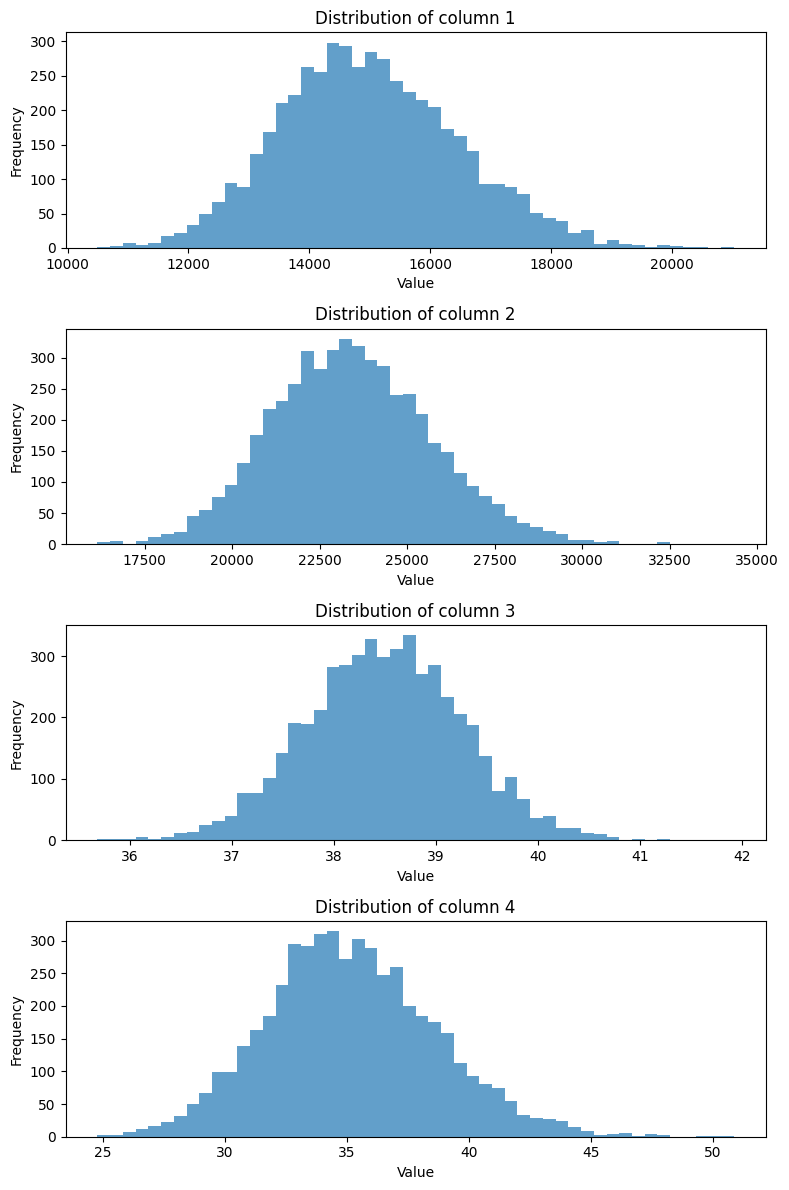

In [16]:
# Create subplots for the distribution of each column
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Plotting the distribution for each column
for i in range(4):
    axs[i].hist(x_mc_scaled[:, i], bins=50, alpha=0.7)
    axs[i].set_title(f'Distribution of column {i+1}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
np.mean(x_mc_scaled, axis=0), np.std(x_mc_scaled, axis=0)

(array([14998.37711073, 23431.07569657,    38.49414026,    35.19202749]),
 array([1.48110628e+03, 2.29270072e+03, 7.70244027e-01, 3.49266619e+00]))

In [ ]:
# max_displacement_mc = np.zeros((int(n_samples)))
# max_baseshear_mc = np.zeros((int(n_samples)))
# for i in range(int(n_samples)):
#     _ , max_displacement_mc[i], max_baseshear_mc[i] = PushoverConcetrated_mod(x_mc_samples[i])

# results = {}
# results['base_shear'] = max_baseshear_mc
# results['displacement'] = max_displacement_mc

# with open('mc_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
with open('mc_results.pkl', 'rb') as f:
    loaded_results = pickle.load(f)

max_baseshear_mc = loaded_results['base_shear']
n_samples = len(max_baseshear_mc)
print(np.max(max_baseshear_mc))

In [43]:
with open('/Users/jonathan/Documents/Batch_AL/Batch_AL/results/four_branch/correlation_det/3/exp_0_20240908_173307.pkl', 'rb') as f:
    results = pickle.load(f)

In [47]:
results['training_samples'][0].shape

torch.Size([103, 2])

In [ ]:
ext12_mean = 38.5      #external mean load at node 12
ext12_std = ext12_mean * 0.2
ext12_load = np.random.normal(ext12_mean, ext12_std, int(n_samples))
np.min(ext12_load)
# ext_load = (2*ext12_load) + (2*ext12_load*ratio_ref)
# ext_load = 2*ext12_load * (1+ratio_ref)
# np.max(ext_load)

# g_pushover = max_baseshear_mc - ext_load
# np.sum(g_pushover<0)/n_samples

Active Learning

In [3]:
from limit_states import REGISTRY as ls_REGISTRY
from utils.data import isoprob_transform
from active_learning.active_learning import BatchActiveLearning

lstate = ls_REGISTRY['four_branch']()

In [ ]:
# # random sampling
# dim = 4
# x_sample = np.zeros(dim)
# # random sampling (gaussian distribution)
# x_sample[0] = np.random.normal(Mybeam_mean, Mybeam_std)   # yield moment at plastic hinge location
# x_sample[1] = np.random.normal(Mycol_mean, Mycol_std)   # yield moment of colum section
# x_sample[2] = np.random.normal(Acol_12_mean, Acol_12_std)  # cross-sectional area (elasticBeamColumn: 111, 121, 112, 122)
# x_sample[3] = np.random.normal(Acol_12_mean, Acol_12_std)  # cross-sectional area (elasticBeamColumn: 111, 121, 112, 122)

# lstate.eval_lstate(x_sample)

In [4]:
active_learning = BatchActiveLearning(n_active_samples= 3)
doe = 10
# random_state = 42
x_train_norm, _, y_train = lstate.get_doe(n_samples=doe, method='lhs')
x_train_norm = torch.tensor(x_train_norm)
y_train = torch.tensor(y_train)

engine humming...


Training

In [5]:
# Training model
kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
model_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
model_gp.fit(x_train_norm, y_train)
print(x_train_norm.shape, y_train.shape)
model_gp.kernel_

torch.Size([10, 2]) torch.Size([10])


1.36**2 * Matern(length_scale=0.709, nu=1.5)

In [12]:
b_samples = 5    #number of required samples from the pool
model = model_gp  #trained GaussianProcessRegressor with input 2 and output 1

# Making predictions of mean and std for mc population 
x_mc = np.random.uniform(0, 1, size=(int(1e5), 2))
mean_prediction, std_prediction = model_gp.predict(x_mc, return_std=True)
mean_pred = torch.tensor(mean_prediction)
std_pred = torch.tensor(std_prediction)

#firs sample evaluated with U_function
selected_indices = active_learning.get_u_function(mean_pred, std_pred, samples=1)

for _ in range(b_samples-1):
    #Covariance computation
    det_cov = []

    for sample in range(len(x_mc)):
        x_assemble = x_mc[selected_indices + [sample]] 
        _, cov_assemble = model.predict(x_assemble, return_std=False, return_cov=True)
        det_ = np.linalg.det(cov_assemble)
        det_cov.append(det_)            

    det_cov = torch.tensor(det_cov)

    #evaluate U_function normalised with det_cov
    u_function = (mean_pred.abs())/det_cov

    #avoid selected values
    u_function[selected_indices] = np.inf

    #adding selected indices
    _, u_min_idx = u_function.topk(1, largest=False)
    selected_indices.append(u_min_idx.item())

print(selected_indices)

[15704, 57899, 65327, 38433, 70120]


In [13]:
b_samples = 5    #number of required samples from the pool
model = model_gp  #trained GaussianProcessRegressor with input 2 and output 1
selected_indices = []

#firs sample evaluated with U_function
selected_indices = active_learning.get_u_function(mean_pred, std_pred, samples=1)

for _ in range(b_samples-1):
    #Covariance computation
    det_cov = []

    for sample in range(len(x_mc)):
        x_assemble = x_mc[selected_indices + [sample]] 
        _, cov_assemble = model.predict(x_assemble, return_std=False, return_cov=True)
        det_ = np.linalg.det(cov_assemble)
        det_cov.append(det_)            

    det_cov = torch.tensor(det_cov)

    #evaluate U_function normalised with det_cov
    u_function = (mean_pred.abs())/det_cov

    #avoid selected values
    u_function[selected_indices] = np.inf

    #adding selected indices
    _, u_min_idx = u_function.topk(1, largest=False)
    selected_indices.append(u_min_idx.item())

print(selected_indices)

[15704, 57899, 65327, 38433, 70120]


In [20]:
from joblib import Parallel, delayed

b_samples = 5  # Number of required samples from the pool
model = model_gp  # Trained GaussianProcessRegressor

selected_indices = []
# First sample evaluated with U_function (external function)
selected_indices = active_learning.get_u_function(mean_pred, std_pred, samples=1)

def calculate_determinant(sample, selected_indices):
    x_assemble = x_mc[selected_indices + [sample]]
    _, cov_assemble = model.predict(x_assemble, return_std=False, return_cov=True)
    return np.linalg.det(cov_assemble)

for _ in range(b_samples - 1):
    # Covariance computation
    # Use parallel processing to calculate the determinants for all samples
    det_cov = Parallel(n_jobs=-1)(delayed(calculate_determinant)(sample, selected_indices) for sample in range(len(x_mc)))

    # Convert to tensor 
    det_cov = torch.tensor(det_cov)

    #evaluate U_function normalised with det_cov
    u_function = (mean_pred.abs())/det_cov

    #avoid selected values
    u_function[selected_indices] = np.inf

    #adding selected indices
    _, u_min_idx = u_function.topk(1, largest=False)
    selected_indices.append(u_min_idx.item())

selected_indices

[15704, 57899, 65327, 38433, 70120]

In [38]:
np.arange(len(x_mc))

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [36]:
min_max_distance(x_train_norm, x_train_norm)

(tensor(0.1095, dtype=torch.float64), tensor(1.0913, dtype=torch.float64))

In [26]:
eigen_values, _ = np.linalg.eig(cov_assemble)
eigen_values

array([1.14782455, 0.05757256, 0.06359573, 0.42501996, 0.49704302])

In [27]:
np.sum(eigen_values)

2.191055818192455

In [19]:
selected_indices

[15704, 57899, 39874, 38433, 85260]

In [ ]:
selected_indices.append(selected_indices)

In [ ]:
# Select the corresponding samples from x_mc_norm
selected_samples_norm = x_mc_norm[selected_indices]

In [ ]:
x_mc_scaled = isoprob_transform(selected_samples_norm, lstate.marginals)

In [ ]:
x_mc_scaled

In [ ]:
mean_prediction[selected_indices]

In [ ]:
from active_learning.active_learning import BatchActiveLearning
active_learning = BatchActiveLearning(b_samples=1)

In [ ]:
active_learning.b_samples

In [ ]:
plt.scatter(x_samples[:,1], max_baseshear, s=5)

plt.xlabel('Horizontal Displacement')
plt.ylabel('Base shear')
plt.show()

Plot levelcurves

In [ ]:
n_grid = 50
# Create a grid of values for X and Y
x_1 = np.linspace(np.min(x_samples[:,0]), np.max(x_samples[:,0]), n_grid)
x_2 = np.linspace(np.min(x_samples[:,1]), np.max(x_samples[:,1]), n_grid)
X1, X2 = np.meshgrid(x_1, x_2)


In [ ]:
# Initialize an empty array for Z
Z_max_displacement = np.zeros_like(X1)
Z_max_baseshear = np.zeros_like(X1)

# Evaluate Z values by iterating over each (x, y) pair
for i in range(X1.shape[0]):
    for j in range(X2.shape[1]):
        _, Z_max_displacement[i, j], Z_max_baseshear[i, j] = PushoverConcetrated_mod(X1[i, j], X2[i, j])

In [ ]:
# Create the contour plot
out_1 = Z_max_baseshear
out_2 = Z_max_displacement
limit_1 = 320 
limit_2 = 2.5
levels = 20

cm = 1/2.54  # centimeters in inches
fig1, axs = plt.subplots(1, 2 , figsize=(50*cm, 20*cm), sharey='row', dpi=80, facecolor='w', edgecolor='k')
plt.subplots_adjust(left=0.3, right=.98, top=0.98, bottom=0.3, hspace = 0.65, wspace=0.05)

contour_x1 = axs[0].contourf(X1, X2, out_1, levels=levels, cmap='viridis', alpha=0.9)
axs[0].clabel(contour_x1, inline=True, fontsize=10, colors='k')
cbar1 = fig1.colorbar(contour_x1, ax=axs[0], orientation='vertical')
axs[0].contour(X1, X2, out_1, levels=[limit_1], colors='red', linestyles='--')
# Add a colorbar for the first contour plot
axs[0].set_title('Max Base Shear')
axs[0].set_ylabel('Yield moment of colum section')
axs[0].set_xlabel('Yield moment at plastic hinge location')
# Add a specific level contour line


contour_x2 = axs[1].contourf(X1, X2, out_2, levels=levels, cmap='viridis', alpha=0.9)
axs[1].clabel(contour_x2, inline=True, fontsize=10, colors='k')
# Add a colorbar for the second contour plot
cbar2 = fig1.colorbar(contour_x2, ax=axs[1], orientation='vertical')
axs[1].contour(X1, X2, out_2, levels=[limit_2], colors='red', linestyles='--')

# cbar2.set_label(f'{str(out_2)}')
axs[1].set_title('Max Displacement')
axs[1].set_xlabel('Yield moment at plastic hinge location')

# Display the plot
plt.show()

In [ ]:

# Compute Z values for the function on the grid
Z = func(X, Y)

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)
plt.colorbar(contour, label='Function Value')
plt.title('Contour Plot of the Function')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()

In [ ]:
# Vectorize the function
PushoverConcetrated_vectorized = np.vectorize(PushoverConcetrated_mod)

In [ ]:
PushoverConcetrated_vectorized(Mybeam)

In [ ]:
import matplotlib.pyplot as plt

# Define the geometry
height = 3.0  # Height of each story (m)
width = 6.0   # Width of the bay (m)

# Node coordinates
nodes = {
    1: (0.0, 0.0),
    2: (width, 0.0),
    3: (0.0, height),
    4: (width, height),
    5: (0.0, 2*height),
    6: (width, 2*height)
}

# Elements connectivity (start_node, end_node)
elements = [
    (1, 3),
    (2, 4),
    (3, 5),
    (4, 6),
    (3, 4),
    (5, 6)
]

# Plotting the structure
fig, ax = plt.subplots()
for element in elements:
    start_node = nodes[element[0]]
    end_node = nodes[element[1]]
    ax.plot([start_node[0], end_node[0]], [start_node[1], end_node[1]], 'k-', lw=2)

# Plot nodes
for node, coord in nodes.items():
    ax.plot(coord[0], coord[1], 'ro')
    ax.text(coord[0], coord[1], f'{node}', fontsize=12, ha='right')

# Set labels and title
ax.set_xlabel('Width (m)')
ax.set_ylabel('Height (m)')
ax.set_title('Zayas Frame Structure')

# Set equal scaling and grid
ax.set_aspect('equal')
ax.grid(True)

plt.show()


In [ ]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Define the model builder
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

# Define material properties
E = 200000.0  # Young's modulus (MPa)
Fy = 345.0    # Yield stress (MPa)
b = 0.01      # Strain hardening ratio
A_col = 0.02  # Cross-sectional area of columns (m^2)
A_beam = 0.015 # Cross-sectional area of beams (m^2)
Iz_col = 8.33e-6  # Moment of inertia of columns (m^4)
Iz_beam = 6.25e-6  # Moment of inertia of beams (m^4)

# Define the geometry
height = 3.0  # Height of each story (m)
width = 6.0   # Width of the bay (m)

# Node coordinates
ops.node(1, 0.0, 0.0)
ops.node(2, width, 0.0)
ops.node(3, 0.0, height)
ops.node(4, width, height)
ops.node(5, 0.0, 2*height)
ops.node(6, width, 2*height)

# Fix supports at base
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# Define materials
ops.uniaxialMaterial('Steel01', 1, Fy, E, b)

# Define the coordinate transformation
ops.geomTransf('Linear', 1)

# Define elements
ops.element('elasticBeamColumn', 1, 1, 3, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 2, 2, 4, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 3, 3, 5, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 4, 4, 6, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 5, 3, 4, A_beam, E, Iz_beam, 1)
ops.element('elasticBeamColumn', 6, 5, 6, A_beam, E, Iz_beam, 1)

# Define gravity loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)
# ops.load(3, 0.0, -10.0, 0.0)
# ops.load(4, 0.0, -10.0, 0.0)
# ops.load(5, 0.0, -10.0, 0.0)
# ops.load(6, 0.0, -10.0, 0.0)
ops.load(3, 1.0, 0.0, 0.0)
ops.load(4, 1.0, 0.0, 0.0)
ops.load(5, 1.0, 0.0, 0.0)
ops.load(6, 1.0, 0.0, 0.0)

# Perform gravity analysis
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-8, 10)
ops.algorithm('Newton')
ops.integrator('LoadControl', 0.1)
ops.analysis('Static')

ops.analyze(10)

# Apply lateral load pattern for pushover analysis
ops.timeSeries('Linear', 2)
ops.pattern('Plain', 2, 2)
ops.load(5, 1.0, 0.0, 0.0)
ops.load(6, 1.0, 0.0, 0.0)

# Modify convergence criteria and algorithm for pushover analysis
ops.integrator('LoadControl', 0.001)  # Load control with a small load increment
ops.test('NormDispIncr', 1.0e-6, 20)                # Convergence tolerance and max iterations
ops.algorithm('NewtonLineSearch', '-type', 'Bisection')  # Use line search for better convergence
ops.analysis('Static')

# Adaptive step size parameters
max_steps = 10
displacements = []
base_shear = []
current_load_increment = 0.001

# Perform pushover analysis with LoadControl
for i in range(max_steps):
    ok = ops.analyze(1)
    if ok != 0:  # If the analysis fails to converge
        current_load_increment /= 2  # Reduce the load increment
        ops.integrator('LoadControl', current_load_increment)
        print(f"Convergence issue at step {i}. Reducing load increment to {current_load_increment}.")
        if current_load_increment < 1e-6:  # Avoid too small increments
            print("Load increment too small, stopping analysis.")
            break
    else:
        displacements.append(ops.nodeDisp(6, 1))
        base_shear.append(ops.nodeReaction(1, 1) + ops.nodeReaction(2, 1))

# Plot pushover curve
plt.plot(displacements, base_shear, '-o')
plt.xlabel('Roof Displacement (m)')
plt.ylabel('Base Shear (kN)')
plt.title('Pushover Curve of the Zayas Frame (LoadControl)')
plt.grid(True)
plt.show()

# Cleanup
ops.wipe()



In [ ]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt

# Define the model builder
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

# Define material properties
E = 200000.0  # Young's modulus (MPa)
Fy = 345.0    # Yield stress (MPa)
b = 0.01      # Strain hardening ratio
A_col = 0.02  # Cross-sectional area of columns (m^2)
A_beam = 0.015 # Cross-sectional area of beams (m^2)
Iz_col = 8.33e-6  # Moment of inertia of columns (m^4)
Iz_beam = 6.25e-6  # Moment of inertia of beams (m^4)
alpha = 0.05
sY = 36.0

# Define the geometry
height = 3.0  # Height of each story (m)
width = 6.0   # Width of the bay (m)

# Node coordinates
ops.node(1, 0.0, 0.0)
ops.node(2, width, 0.0)
ops.node(3, 0.0, height)
ops.node(4, width, height)
ops.node(5, 0.0, 2*height)
ops.node(6, width, 2*height)

# Fix supports at base
ops.fix(1, 1, 1, 1)
ops.fix(2, 1, 1, 1)

# Define materials
# ops.uniaxialMaterial('Steel01', 1, Fy, E, b)
ops.uniaxialMaterial("Hardening", 1, E, sY, 0.0, alpha/(1-alpha)*E)
# Define the coordinate transformation
ops.geomTransf('Linear', 1)

# Define elements
ops.element('elasticBeamColumn', 1, 1, 3, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 2, 2, 4, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 3, 3, 5, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 4, 4, 6, A_col, E, Iz_col, 1)
ops.element('elasticBeamColumn', 5, 3, 4, A_beam, E, Iz_beam, 1)
ops.element('elasticBeamColumn', 6, 5, 6, A_beam, E, Iz_beam, 1)

# Define gravity loads
ops.timeSeries('Linear', 1)
ops.pattern('Plain', 1, 1)
ops.load(3, 0.0, -10.0, 0.0)
ops.load(4, 0.0, -10.0, 0.0)
ops.load(5, 0.0, -10.0, 0.0)
ops.load(6, 0.0, -10.0, 0.0)

# Perform gravity analysis
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-8, 10)
ops.algorithm('Newton')
ops.integrator('LoadControl', 0.1)
ops.analysis('Static')

ops.analyze(10)

# Apply lateral load pattern for pushover analysis
ops.timeSeries('Linear', 2)
ops.pattern('Plain', 2, 2)
ops.load(5, 1.0, 0.0, 0.0)
ops.load(6, 1.0, 0.0, 0.0)

# Perform pushover analysis
ops.integrator('DisplacementControl', 6, 1, 0.01)
ops.test('NormDispIncr', 1.0e-8, 10)
ops.analysis('Static')

# Store results
displacements = []
base_shear = []

ok = 0
while ok == 0:
    ok = ops.analyze(1)
    displacements.append(ops.nodeDisp(6, 1))
    # base_shear.append(ops.getTime())
    base_shear.append(ops.nodeReaction(1, 1))

# Plot pushover curve
plt.plot(displacements, base_shear, '-o')
plt.xlabel('Roof Displacement (m)')
plt.ylabel('Base Shear (kN)')
plt.title('Pushover Curve of the Zayas Frame')
plt.grid(True)
plt.show()

# Cleanup
ops.wipe()


In [ ]:
import openseespy.opensees as ops

# SET UP ----------------------------------------------------------------------------
ops.wipe()                      # clear opensees model
ops.model('basic', '-ndm', 2, '-ndf', 3)  # 2 dimensions, 3 dof per node

# define GEOMETRY -------------------------------------------------------------
# nodal coordinates:
ops.node(1, 0, 0)               # node#, X Y
ops.node(2, 504, 0)
ops.node(3, 0, 432)
ops.node(4, 504, 432)

# Single point constraints -- Boundary Conditions
ops.fix(1, 1, 1, 1)             # node DX DY RZ
ops.fix(2, 1, 1, 1)             # node DX DY RZ
ops.fix(3, 0, 0, 0)
ops.fix(4, 0, 0, 0)

# nodal masses:
ops.mass(3, 5.18, 0.0, 0.0)     # node#, Mx My Mz, Mass=Weight/g.
ops.mass(4, 5.18, 0.0, 0.0)

# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness and resisting force from the basic system to the global-coordinate system
ops.geomTransf('Linear', 1)     # associate a tag to transformation

# connectivity: (make A very large, 10e6 times its actual value)
ops.element('elasticBeamColumn', 1, 1, 3, 3600000000, 4227, 1080000, 1)  # element elasticBeamColumn $eleTag $iNode $jNode $A $E $Iz $transfTag
ops.element('elasticBeamColumn', 2, 2, 4, 3600000000, 4227, 1080000, 1)
ops.element('elasticBeamColumn', 3, 3, 4, 5760000000, 4227, 4423680, 1)

# Define RECORDERS -------------------------------------------------------------
ops.recorder('Node', '-file', 'Data/DFree.out', '-time', '-node', 3, 4, '-dof', 1, 2, 3, 'disp')  # displacements of free nodes
ops.recorder('Node', '-file', 'Data/DBase.out', '-time', '-node', 1, 2, '-dof', 1, 2, 3, 'disp')  # displacements of support nodes
ops.recorder('Node', '-file', 'Data/RBase.out', '-time', '-node', 1, 2, '-dof', 1, 2, 3, 'reaction')  # support reaction
# ops.recorder('Drift', '-file', 'Data/Drift.out', '-time', '-iNode', 1, 2, '-jNode', 3, 4, '-dof', 1, '-perpDirn', 2)  # lateral drift
ops.recorder('Element', '-file', 'Data/FCol.out', '-time', '-ele', 1, 2, 'globalForce')  # element forces -- column
ops.recorder('Element', '-file', 'Data/FBeam.out', '-time', '-ele', 3, 'globalForce')  # element forces -- beam

# define GRAVITY -------------------------------------------------------------
ops.timeSeries("Linear", 1)
ops.pattern('Plain', 1, 1) 
ops.eleLoad('-ele', 3, '-type', '-beamUniform', -7.94)  # distributed superstructure-weight on beam

ops.constraints('Plain')                # how it handles boundary conditions
ops.numberer('Plain')                   # renumber dof's to minimize band-width (optimization), if you want to
ops.system('BandGeneral')               # how to store and solve the system of equations in the analysis
ops.test('NormDispIncr', 1.0e-8, 6)     # determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')                 # use Newton's solution algorithm: updates tangent stiffness at every iteration
ops.integrator('LoadControl', 0.1)      # determine the next time step for an analysis, # apply gravity in 10 steps
ops.analysis('Static')                  # define type of analysis static or transient
ops.analyze(10)                         # perform gravity analysis
ops.loadConst('-time', 0.0)             # hold gravity constant and restart time

# define LATERAL load -------------------------------------------------------------
# Lateral load pattern
ops.timeSeries("Linear", 2)
ops.pattern('Plain', 2, 2)
ops.load(3, 2000.0, 0.0, 0.0)           # node#, FX FY MZ -- representative lateral load at top nodes
ops.load(4, 2000.0, 0.0, 0.0)           # place 1/2 of the weight for each node to get shear coefficient

# pushover: displacement controlled static analysis
ops.integrator('DisplacementControl', 3, 1, 0.1)   # switch to displacement control, for node 3, dof 1, 0.1 increment
ops.analyze(100)                        # apply 100 steps of pushover analysis to a displacement of 10

print("Done!")


In [ ]:
ops.nodeDisp(3, 3)

In [ ]:
from openseespy.opensees import *

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Start of model generation
# -----------------------------

# set modelbuilder
wipe()
model('basic', '-ndm', 2, '-ndf', 2)

# variables
A = 4.0
E = 29000.0
alpha = 0.05
sY = 36.0
udisp = 2.5
Nsteps = 1000
Px = 160.0
Py = 10.0

# create nodes
node(1, 0.0, 0.0)
node(2, 72.0, 0.0)
node(3, 168.0, 0.0)
node(4, 48.0, 144.0)

# set boundary condition
fix(1, 1, 1)
fix(2, 1, 1)
fix(3, 1, 1)

# define materials
uniaxialMaterial("Hardening", 1, E, sY, 0.0, alpha/(1-alpha)*E)

# define elements
element("Truss",1,1,4,A,1)
element("Truss",2,2,4,A,1)
element("Truss",3,3,4,A,1)

# create TimeSeries
timeSeries("Linear", 1)

# create a plain load pattern
pattern("Plain", 1, 1)

# Create the nodal load
load(4, Px, Py)

# ------------------------------
# Start of analysis generation
# ------------------------------

# create SOE
system("ProfileSPD")

# create DOF number
numberer("Plain")

# create constraint handler
constraints("Plain")

# create integrator
integrator("LoadControl", 1.0/Nsteps)

# create algorithm
algorithm("Newton")

# create test
test('NormUnbalance',1e-8, 10)

# create analysis object
analysis("Static")

# ------------------------------
# Finally perform the analysis
# ------------------------------
factor=10
# perform the analysis
data = np.zeros((factor*Nsteps+1,2))
for j in range(factor*Nsteps):
    analyze(1)
    data[j+1,0] = nodeDisp(4,1)
    # data[j+1,1] = getLoadFactor(1)*Px
    data[j+1,1] = eleResponse(2,'forces')[1]

plt.plot(data[:,0], data[:,1])
plt.xlabel('Horizontal Displacement')
plt.ylabel('Horizontal Load')
plt.show()

In [ ]:
nodeReaction(1),nodeReaction(2),nodeReaction(3)

In [ ]:
eleResponse(1,'forces')

In [ ]:
eleResponse(2,'forces')

In [ ]:
eleResponse(3,'forces')

In [ ]:
from openseespy.opensees import *

from math import asin, sqrt

# Two dimensional Frame: Eigenvalue & Static Loads


# REFERENCES:
# used in verification by SAP2000:
# SAP2000 Integrated Finite Element Analysis and Design of Structures, Verification Manual,
# Computers and Structures, 1997. Example 1.
# and seismo-struct (Example 10)
# SeismoStruct, Verification Report For Version 6, 2012. Example 11.


# set some properties
wipe()

model('Basic', '-ndm', 2)

# properties

#    units kip, ft

numBay = 2
numFloor = 7

bayWidth = 360.0
storyHeights = [162.0, 162.0, 156.0, 156.0, 156.0, 156.0, 156.0]

E = 29500.0
massX = 0.49
M = 0.
coordTransf = "Linear"  # Linear, PDelta, Corotational
massType = "-lMass"  # -lMass, -cMass

beams = ['W24X160', 'W24X160', 'W24X130', 'W24X130', 'W24X110', 'W24X110', 'W24X110']
eColumn = ['W14X246', 'W14X246', 'W14X246', 'W14X211', 'W14X211', 'W14X176', 'W14X176']
iColumn = ['W14X287', 'W14X287', 'W14X287', 'W14X246', 'W14X246', 'W14X211', 'W14X211']
columns = [eColumn, iColumn, eColumn]

WSection = {
    'W14X176': [51.7, 2150.],
    'W14X211': [62.1, 2670.],
    'W14X246': [72.3, 3230.],
    'W14X287': [84.4, 3910.],
    'W24X110': [32.5, 3330.],
    'W24X130': [38.3, 4020.],
    'W24X160': [47.1, 5120.]
}

nodeTag = 1


# procedure to read
def ElasticBeamColumn(eleTag, iNode, jNode, sectType, E, transfTag, M, massType):
    found = 0

    prop = WSection[sectType]

    A = prop[0]
    I = prop[1]
    element('elasticBeamColumn', eleTag, iNode, jNode, A, E, I, transfTag, '-mass', M, massType)


# add the nodes
#  - floor at a time
yLoc = 0.
for j in range(0, numFloor + 1):

    xLoc = 0.
    for i in range(0, numBay + 1):
        node(nodeTag, xLoc, yLoc)
        xLoc += bayWidth
        nodeTag += 1

    if j < numFloor:
        storyHeight = storyHeights[j]

    yLoc += storyHeight

# fix first floor
fix(1, 1, 1, 1)
fix(2, 1, 1, 1)
fix(3, 1, 1, 1)

# rigid floor constraint & masses
nodeTagR = 5
nodeTag = 4
for j in range(1, numFloor + 1):
    for i in range(0, numBay + 1):

        if nodeTag != nodeTagR:
            equalDOF(nodeTagR, nodeTag, 1)
        else:
            mass(nodeTagR, massX, 1.0e-10, 1.0e-10)

        nodeTag += 1

    nodeTagR += numBay + 1

# add the columns
# add column element
geomTransf(coordTransf, 1)
eleTag = 1
for j in range(0, numBay + 1):

    end1 = j + 1
    end2 = end1 + numBay + 1
    thisColumn = columns[j]

    for i in range(0, numFloor):
        secType = thisColumn[i]
        ElasticBeamColumn(eleTag, end1, end2, secType, E, 1, M, massType)
        end1 = end2
        end2 += numBay + 1
        eleTag += 1

# add beam elements
for j in range(1, numFloor + 1):
    end1 = (numBay + 1) * j + 1
    end2 = end1 + 1
    secType = beams[j - 1]
    for i in range(0, numBay):
        ElasticBeamColumn(eleTag, end1, end2, secType, E, 1, M, massType)
        end1 = end2
        end2 = end1 + 1
        eleTag += 1

# calculate eigenvalues & print results
numEigen = 7
eigenValues = eigen(numEigen)
PI = 2 * asin(1.0)

#
# apply loads for static analysis & perform analysis
#

timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(22, 20.0, 0., 0.)
load(19, 15.0, 0., 0.)
load(16, 12.5, 0., 0.)
load(13, 10.0, 0., 0.)
load(10, 7.5, 0., 0.)
load(7, 5.0, 0., 0.)
load(4, 2.5, 0., 0.)

integrator('LoadControl', 1.0)
algorithm('Linear')
analysis('Static')
analyze(1)

# determine PASS/FAILURE of test
ok = 0

#
# print pretty output of comparisons
#

#               SAP2000   SeismoStruct
comparisonResults = [[1.2732, 0.4313, 0.2420, 0.1602, 0.1190, 0.0951, 0.0795],
                     [1.2732, 0.4313, 0.2420, 0.1602, 0.1190, 0.0951, 0.0795]]
print("\n\nPeriod Comparisons:")
print('{:>10}{:>15}{:>15}{:>15}'.format('Period', 'OpenSees', 'SAP2000', 'SeismoStruct'))

# formatString {%10s%15.5f%15.4f%15.4f}
for i in range(0, numEigen):
    lamb = eigenValues[i]
    period = 2 * PI / sqrt(lamb)
    print('{:>10}{:>15.5f}{:>15.4f}{:>15.4f}'.format(i + 1, period, comparisonResults[0][i], comparisonResults[1][i]))
    resultOther = comparisonResults[0][i]
    if abs(period - resultOther) > 9.99e-5:
        ok - 1

# print table of comparision
#       Parameter          SAP2000   SeismoStruct
comparisonResults = [["Disp Top", "Axial Force Bottom Left", "Moment Bottom Left"],
                     [1.45076, 69.99, 2324.68],
                     [1.451, 70.01, 2324.71]]
tolerances = [9.99e-6, 9.99e-3, 9.99e-3]

print("\n\nSatic Analysis Result Comparisons:")
print('{:>30}{:>15}{:>15}{:>15}'.format('Parameter', 'OpenSees', 'SAP2000', 'SeismoStruct'))
for i in range(3):
    response = eleResponse(1, 'forces')
    if i == 0:
        result = nodeDisp(22, 1)
    elif i == 1:
        result = abs(response[1])
    else:
        result = response[2]

    print('{:>30}{:>15.3f}{:>15.2f}{:>15.2f}'.format(comparisonResults[0][i],
                                                     result,
                                                     comparisonResults[1][i],
                                                     comparisonResults[2][i]))
    resultOther = comparisonResults[1][i]
    tol = tolerances[i]
    if abs(result - resultOther) > tol:
        ok - 1
        print("failed-> ", i, abs(result - resultOther), tol)

if ok == 0:
    print("PASSED Verification Test PortalFrame2d.py \n\n")
else:
    print("FAILED Verification Test PortalFrame2d.py \n\n")